In [16]:
import torch
import dgl
import networkx as nx

In [4]:
dataset = dgl.data.GINDataset("PROTEINS", self_loop=True)

Extracting file to /Users/marc/.dgl/GINDataset


In [32]:
torch.bincount(dataset[:][1])

tensor([663, 450])

In [13]:
g = dataset[0][0]
options = {
    "node_color": "black",
    "node_size": 20,
    "width": 1,
}
G = dgl.to_networkx(g)

In [2]:
dataset[0][:]

NameError: name 'dataset' is not defined

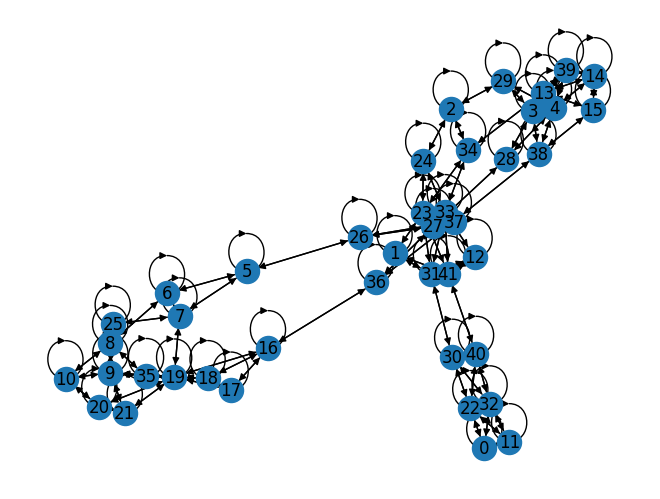

In [25]:
nx.draw(G, with_labels=True)